<a href="https://colab.research.google.com/github/pierresegonne/ELEC5307_Project1/blob/master/project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project 1 report

## Pierre Segonne 490547607

Please follow the instructions carefully:
- This project is based on Cifar-10 dataset. The basic loading operations are added already. Please do not use other dataset.
- Remove the corresponding `e.g.` and fill in all the blanks in this file, including some codes in Part 1, your choices for Part 2, your task for Part 3, and the analyses for your choices, specification of your computer, etc.
- Please do not change the format of this report.
- In your analyses, you can add math functions and graphs.
- Please make clear comments and references for any codes written by yourself or copied from other sources.

### Part 0: Prepare for Colab

If you work on online GPU servers, e.g. [Google Colab](https://colab.research.google.com), you need to first install PyTorch each time you run the file. You can also upload file and load files from your google drive.
Besides, you can also select GPU as Hardware accelerator in Edit->Notebook settings. 

Remember to run some of the following blocks if you work on Google Colab. You can ignore this part if you are not using Google Colab (e.g, if you are use lab machines, your own computers or AWS servers (Windows)).

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=c1b60b328b16c22eafd92b7218f3511f85a185e57bb64b5eb3f30d2f235ebdff
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 256.5 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
# Install pytorch

from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'
print('Accelerator: ', accelerator)

print('Installing Torch') 
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl
# Issue with torchvision version
!pip install torchvision==0.2.1
import torch
import torchvision

Accelerator:  cu80
Installing Torch
     |████████████████████████████████| 532.5MB 61.2MB/s 
ERROR: torchvision 0.4.0 has requirement torch==1.2.0, but you'll have torch 1.0.0 which is incompatible.
     |████████████████████████████████| 61kB 2.4MB/s 
  Found existing installation: torchvision 0.4.0
    Uninstalling torchvision-0.4.0:
      Successfully uninstalled torchvision-0.4.0


In [1]:
# upload files to Colab
from google.colab import files
files.upload()

### Part 1: Baseline model
You need to run this model successfully to get the marks. You should finish the codes that are used to split the training dataset into training set (45000 images) and validation set (5000 images) and draw the loss curve for training loss and validation loss. 

### 1.1 prepare data

In [0]:
# useful packages
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn

# OWN 
import numpy as np


In [0]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


### 1.2 split the training data into training and validation
In most of the cases, you are given the test set, so you need to prepare some validation data to evaluate your model during training stage. You need to make a validation dataset that contains 5000 training images, and the rest 45000 images are used as the new training set.

In [0]:
# Your split codes here.
# You need to random select the 5000 validation images 

# besides, you can also make modifications for faster training 
# by selecting a subset of the original dataset.

from torch.utils.data import SubsetRandomSampler

VALIDATION_SET_SIZE = 5000
BATCH_SIZE = 4

"""
For debug purposes, we want to use only a small portion of the dataset.
"""
DEBUG = False

if DEBUG:
    indices = np.arange(200)
    np.random.shuffle(indices)
    split = int(len(indices)*0.8)
else:
    indices = np.arange(len(trainset))
    np.random.shuffle(indices) # for shuffle = True
    split = len(trainset) - VALIDATION_SET_SIZE

validation_set_size = len(indices) - split

train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])
    
train_loader = torch.utils.data.DataLoader(trainset,
                                           batch_size=BATCH_SIZE,
                                           num_workers=2,
                                           sampler=train_sampler
                                          )
validation_loader = torch.utils.data.DataLoader(trainset,
                                                batch_size=BATCH_SIZE,
                                                num_workers=2,
                                                sampler=validation_sampler
                                               )



### 1.3 Define a Baseline Convolution Neural Network

In [0]:
# Omission
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### 1.4 Define a Loss function and optimizer

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


### 1.5 Train the network

In [0]:
# own:
trainloader = train_loader
validationloader = validation_loader

if DEBUG:
    print_every = 20
else:
    print_every = 2000
    
training_loss = []
validation_loss = []

for epoch in range(5):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % print_every == (print_every - 1):
            
            # Training loss
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            training_loss.append(running_loss / print_every)
            running_loss = 0.0
            
            # Validation loss
            running_validation_loss = 0
            for indices, data in enumerate(validationloader, 0):
                inputs, labels = data
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                running_validation_loss += loss.item()
            validation_loss.append(running_validation_loss / (validation_set_size/BATCH_SIZE))

print('Finished Training')

[1,  2000] loss: 2.289
[1,  4000] loss: 2.056
[1,  6000] loss: 1.876
[1,  8000] loss: 1.706
[1, 10000] loss: 1.627
[2,  2000] loss: 1.535
[2,  4000] loss: 1.503
[2,  6000] loss: 1.448
[2,  8000] loss: 1.442
[2, 10000] loss: 1.406
[3,  2000] loss: 1.345
[3,  4000] loss: 1.347
[3,  6000] loss: 1.322
[3,  8000] loss: 1.326
[3, 10000] loss: 1.299
[4,  2000] loss: 1.232
[4,  4000] loss: 1.235
[4,  6000] loss: 1.227
[4,  8000] loss: 1.234
[4, 10000] loss: 1.234
[5,  2000] loss: 1.131
[5,  4000] loss: 1.164
[5,  6000] loss: 1.169
[5,  8000] loss: 1.163
[5, 10000] loss: 1.160
Finished Training


### 1.6 visualize the loss and accuracy
Using the loss of both training data and validation data to evaluate the model. You may need to change some of the codes in 1.5 in order to save the loss into different lists.

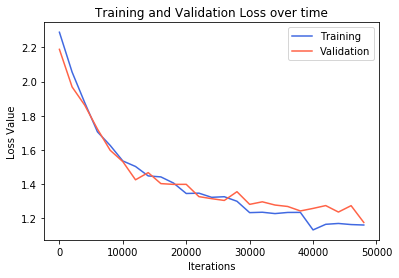

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show the loss
iterations = np.arange(len(training_loss)) * print_every
plt.figure()
plt.title('Training and Validation Loss over time')
plt.plot(iterations, training_loss, '-', color='royalblue')
plt.plot(iterations, validation_loss, '-', color='tomato')
plt.legend(['Training', 'Validation'])
plt.xlabel('Iterations')
plt.ylabel('Loss Value')
plt.show()


### 1.7 Eval the trained network

In [0]:
def eval_net(net, testloader):
    net = net.eval()
    if torch.cuda.is_available():
        net = net.cuda()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            if torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            if torch.cuda.is_available():
              outputs = outputs.cpu()
              labels = labels.cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Own
    accuracy = 100 * correct / total
    
    print('Accuracy of the network on the 10000 test images: %d %%' % (accuracy))
    return accuracy

EVAL_INITIAL = False
if EVAL_INITIAL:
  eval_net(net, testloader)

### Part 2: Hyperparameters Selection
Following the instruction file, you need to make choices for each hyperparameters:

1. Batch size:
2. Base learning rate:
3. Number of epochs: 

**Question**: Why do you make such choices? Use some figures, math equations, codes and printout to make analysis.

### Google Colab File Saving UTILS

In [0]:
ROOT_DIRECTORY = '.'

In [0]:
"""
Allow saving files to google drive if ran on colab.
Useful to keep records of loss evolution for different training runs
And to save figures.

Not required to run the code.
"""
from google.colab import drive
drive.mount('/content/gdrive')
ROOT_DIRECTORY = '/content/gdrive/My Drive/Colab Notebooks/ELEC5307 Project1'




Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


### Definition of the Samplers

In [0]:
from torch.utils.data import SubsetRandomSampler

"""
For debug purposes, we want to use only a small portion of the dataset.
"""
DEBUG = False
VALIDATED_SET_SIZE = 5000
"""
To test out the training with different hyperparameters, we want to use only
a scaled down (in terms of number of images) version of the dataset.
"""
ACCELERATED_TRAINING = False
SCALING_FACTOR = 5

def generate_samplers(trainset, debug=False, accelerated_training=False, scaling_factor=5):

    if debug:
        indices = np.arange(200)
        np.random.shuffle(indices)
        split = int(len(indices)*0.8)
        record_every = 20

    elif accelerated_training:
        indices = np.arange(len(trainset))
        np.random.shuffle(indices)
        indices = indices[:int(len(trainset)/scaling_factor)]
        split = int(len(indices)*0.8) # Can't use 5000 values for validation, use more traditional 80/20 split
        record_every = int(2000 / scaling_factor)

    else:
        indices = np.arange(len(trainset))
        np.random.shuffle(indices)
        split = len(trainset) - VALIDATION_SET_SIZE
        record_every = 2000


    validation_set_size = len(indices) - split

    train_sampler, validation_sampler = SubsetRandomSampler(indices[:split]), SubsetRandomSampler(indices[split:])

    return train_sampler, validation_sampler, record_every
  
train_sampler, validation_sampler, RECORD_EVERY = generate_samplers(trainset, debug=DEBUG, accelerated_training=ACCELERATED_TRAINING, scaling_factor=SCALING_FACTOR)

### Training Function

In [0]:
import os
import pickle
import matplotlib.pyplot as plt
import torch.optim as optim

def serializeObject(obj, fileName):
    with open(fileName, 'wb') as fileHandler:
        pickle.dump(obj, fileHandler, protocol=pickle.HIGHEST_PROTOCOL)

def readPickled(fileName):
    pickledData = {}
    try:
        if os.path.getsize(fileName) > 0:      
            with open(fileName, "rb") as f:
                unpickler = pickle.Unpickler(f)
                # if file is not empty scores will be equal
                # to the value unpickled
                pickledData = unpickler.load()
    except FileNotFoundError:
        raise FileNotFoundError('FILE NOT FOUND!: {0}'.format(fileName))
    return pickledData

def train_network(ann, train_loader, validation_loader,
                  batch_size=2, lr=0.0001, epoch=2,
                  download=False, root_directory='',
                  record_every=20):
    ann = ann.train()
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(ann.parameters(), lr=lr, momentum=0.9)
    
    training_loss = []
    validation_loss = []  

    validation_set_size = len(validation_loader.sampler)

    for e in range(epoch):
        
        running_loss = 0.
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = ann(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if torch.cuda.is_available():
                loss = loss.cpu()
            running_loss += loss.item()
            
            if i % record_every == (record_every - 1):
                print('[%d, %5d] loss: %.3f' %
                      (e + 1, i + 1, running_loss / record_every))
                # Training loss
                training_loss.append(running_loss / record_every)
                running_loss = 0.0
            
                # Validation loss
                running_validation_loss = 0
                for indices, data in enumerate(validation_loader, 0):
                    inputs, labels = data
                    if torch.cuda.is_available():
                        inputs, labels = inputs.cuda(), labels.cuda()
                    outputs = ann(inputs)
                    loss = criterion(outputs, labels)
                    if torch.cuda.is_available():
                        loss = loss.cpu()
                    running_validation_loss += loss.item()
                validation_loss.append(running_validation_loss / (validation_set_size/batch_size))
    
    
    if download:
        dir_name = '{0}/training_recording/bs{1},lr{2},epoch{3}'.format(root_directory, batch_size, lr, epoch)
        if not os.path.exists(dir_name):
            os.makedirs(dir_name)
        
        # Save losses for eventual future use
        serializeObject(training_loss, dir_name + '/training_loss.pickle')
        serializeObject(validation_loss, dir_name + '/validation_loss.pickle')

        # Save network weights for eventual future use
        torch.save(ann.state_dict(), dir_name + '/network_weights.pth')
        
        iterations = np.arange(len(training_loss))*record_every
        plt.figure()
        plt.title('Training and Validation Loss During Training')
        plt.xlabel('Iterations')
        plt.ylabel('Loss Value')
        plt.plot(iterations, training_loss, '-', color='royalblue')
        plt.plot(iterations, validation_loss, '-', color='tomato')
        plt.legend(['Training', 'Validation'])
        plt.savefig(dir_name + '/e{0},lr{1},bs{2}.png'.format(epoch, lr, batch_size), bbox_inches='tight')

        
    
    return ann

### Evaluation of the Parameters

In [0]:
# Your codes here. 
# Please do not define the networks again, just make changes to the training procedure, i.e. in the loop, please go through all the potential choices.
batch_sizes = [2, 4, 8]
learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
epochs = [1, 2, 4, 8, 16]

'''
How to do that though? If we test all combinations, we end up with 90 models to test. 
We could decrease that number by manually removing options:
[4,8]
[0.0005, 0.0001, 0.00005]
[2,4,8]
-> 18, much more reasonable

We save data and plots for all and study the variations.
'''
batch_sizes = [4, 8]
learning_rates = [0.005, 0.001, 0.0005, 0.0001]
epochs = [8, 16]


In [0]:
GENERALIZATION_RUNS = 3

[1,  2000] loss: 2.249
[1,  4000] loss: 1.961
[2,  2000] loss: 1.639
[2,  4000] loss: 1.563
[3,  2000] loss: 1.434
[3,  4000] loss: 1.419
[4,  2000] loss: 1.328
[4,  4000] loss: 1.314
[5,  2000] loss: 1.249
[5,  4000] loss: 1.236
[6,  2000] loss: 1.175
[6,  4000] loss: 1.171
[7,  2000] loss: 1.103
[7,  4000] loss: 1.132
[8,  2000] loss: 1.061
[8,  4000] loss: 1.084
[9,  2000] loss: 1.013
[9,  4000] loss: 1.035
[10,  2000] loss: 0.973
[10,  4000] loss: 0.981
[11,  2000] loss: 0.933
[11,  4000] loss: 0.954
[12,  2000] loss: 0.889
[12,  4000] loss: 0.914
[13,  2000] loss: 0.837
[13,  4000] loss: 0.894
[14,  2000] loss: 0.821
[14,  4000] loss: 0.856
[15,  2000] loss: 0.781
[15,  4000] loss: 0.825
[16,  2000] loss: 0.767
[16,  4000] loss: 0.784
Accuracy of the network on the 10000 test images: 61 %
[1,  2000] loss: 2.275
[1,  4000] loss: 1.998
[2,  2000] loss: 1.639
[2,  4000] loss: 1.562
[3,  2000] loss: 1.458
[3,  4000] loss: 1.405
[4,  2000] loss: 1.323
[4,  4000] loss: 1.315
[5,  2000] 

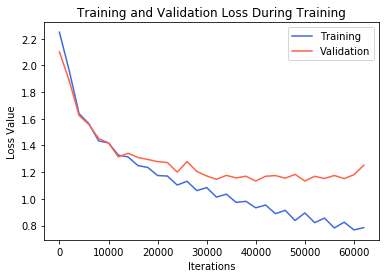

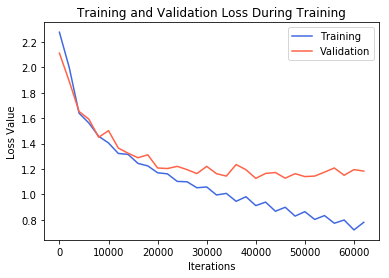

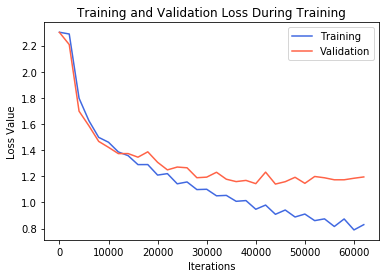

In [0]:
# Generate all possibilities
parameters = [{"batch_size": bs, "lr": lr, "epoch": e} for bs in batch_sizes for lr in learning_rates for e in epochs]

# Will record generalisation error in a 3d tensor.
# i = epoch, j = lr, k = bs
test_error = np.zeros((len(epochs), len(learning_rates), len(batch_sizes)), dtype=object)
test_error_std = np.zeros((len(epochs), len(learning_rates), len(batch_sizes)), dtype=object)

DOWNLOAD = True

i, j, k = 0, 0, 0
for params in parameters:

    generalization_error = []
    for generalization_run in range(GENERALIZATION_RUNS):
        
        # Reset Network
        net = Net()

        # Regenerate samplers
        train_sampler, validation_sampler, record_every = generate_samplers(trainset, 
                                                                            accelerated_training=ACCELERATED_TRAINING, scaling_factor=SCALING_FACTOR)
        
        # Update train loader and validation loader accordingly
        train_loader = torch.utils.data.DataLoader(trainset,
                                              batch_size=params["batch_size"],
                                              num_workers=2,
                                              sampler=train_sampler
                                              )
        validation_loader = torch.utils.data.DataLoader(trainset,
                                                    batch_size=params["batch_size"],
                                                    num_workers=2,
                                                    sampler=validation_sampler
                                                  )
        
        net = train_network(net, train_loader, validation_loader,
                            batch_size=params['batch_size'], lr=params['lr'], epoch=params['epoch'],
                            download=DOWNLOAD, root_directory=ROOT_DIRECTORY,
                            record_every=record_every)
        
        generalization_error.append(eval_net(net, testloader))

    generalization_error = np.array(generalization_error)

    test_error[i][j][k] = generalization_error.mean()
    test_error_std[i][j][k] = generalization_error.std()

    # Update of the tensor indices
    i += 1
    if i == test_error.shape[0]:
        j += 1
        i = 0
        if j == test_error.shape[1]:
            k += 1
            j = 0
            if k == test_error.shape[2]:
                k = 0

# Save the error tensor
serializeObject(test_error, ROOT_DIRECTORY + '/test_error.pickle')
serializeObject(test_error_std, ROOT_DIRECTORY + '/test_error_std.pickle')
    
    
    

### Generate Plot for Accuracy For Different Hyperparameters

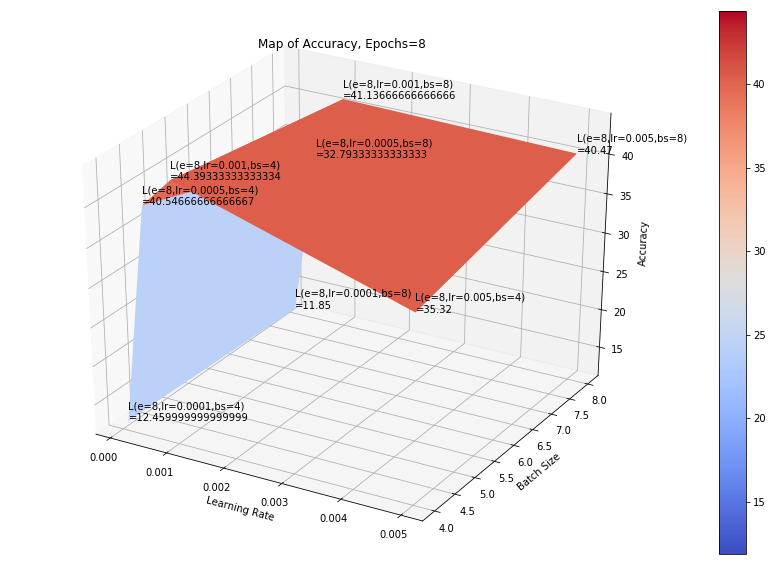

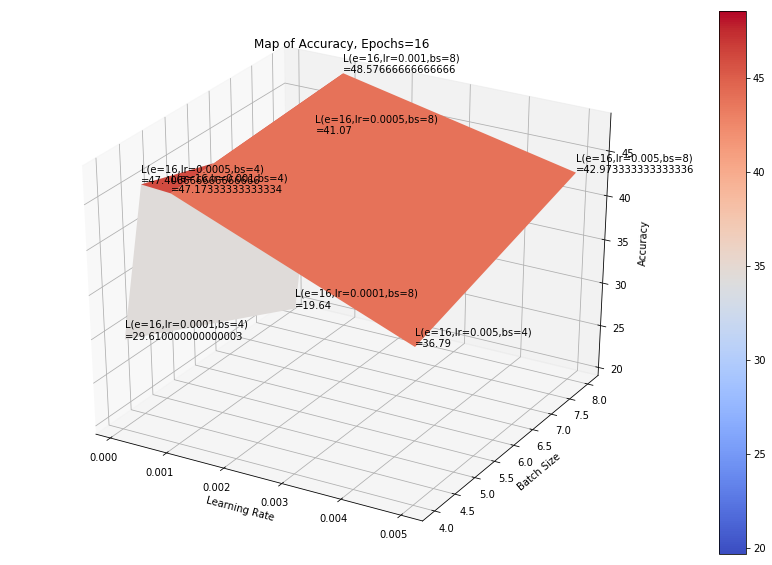

In [0]:


from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D

RECOVER=True
if RECOVER:
  test_error=readPickled(ROOT_DIRECTORY + '/test_error.pickle')


# Generate data visualization for test error
X,Y = np.meshgrid(learning_rates, batch_sizes)
for index, e in enumerate(epochs):
    Z = test_error[index].T
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    plt.title('Map of Accuracy, Epochs={0}'.format(e))
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Batch Size')
    ax.set_zlabel('Accuracy')
    # Wireframe
    #ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1)
    # Surface Plot
    surf = ax.plot_surface(
        X, Y, Z,
        cmap=cm.coolwarm,
        norm=colors.Normalize(vmin=Z.min(), vmax=Z.max()),
        rstride=1, cstride=1,
        linewidth=0, antialiased=True)
    fig.colorbar(surf)
    # Coordinates of Points
    for lr_i, lr in enumerate(learning_rates):
        for bs_i, bs in enumerate(batch_sizes):
            coordinates = 'L(e={},lr={},bs={})\n={}'.format(e,lr,bs,test_error[index][lr_i][bs_i])
            ax.text(lr, bs, test_error[index][lr_i][bs_i], coordinates )

plt.show()



##### Analysis
-----

The initial choices provided for the hyperparameters were:

| Hyperparameter  | Choices |
| --------------  | ------- |
| Epochs          | `[1, 2, 4, 8, 16]`    |
| Learning Rate   | `[0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]`    |
| Batch Size      | `[2, 4, 8]`    |

__Ideally__, to study the effects of the choice of the hyperparameters on the performance of the classifier, we would want to test every combination (ex: `{batch_size = 2, learning_rate = 0.0005, epochs = 2}`), at least five times, estimate the perfomance - using the average on five training runs would help provide a less biased estimation of the real performance of the classifier with the given hyperparameters - and compare all of them.

__In Practice__, this method is not efficient and does not leverage the knowledge we already have of the effects of the different hyperparameters on the training of the classifier.

1. Number of Epochs: 

It is defined as the number of times the classifier will be trained on the whole training set. This parameter has a great influence on the model's ability to fit the data. If the number of epoch is too low (e.g 1) then the classifier will only be able to see each image in the dataset once. Therefore preventing any consequential training. This will result in underfitting. On the other hand, if the number of epoch is too high, then the classifier will fit the training data too closely and will have poor generalization ability, as can be seen in the following graph:

![overfitting](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/overfitting.png)


A subset of only 200 pictures from the CIFAR-10 dataset was used to train the pre-defined convolutional neural network for 50 epochs. The overfitting appears quite clearly; the training loss keeps decreasing while the validation loss increases. 

Finding the optimal number of epochs therefore requires to monitor the evolution of the training and validation loss, until a divergence occurs. Generally, the most complex the model trained is, the later this divergence occurs. State of the art, or near state of the art models on the CIFAR-10, such as [1], reach their maximal accuracy with a great number of epochs (300 epochs for [1]), but have greater parametrical complexity (greater than a million for [1], versus the 61250 parameters of the pre-defined model for this part of the assignment).


*The values of epochs 1, 2 and 4 will therefore be discarded right away. It leaves `[8, 16]` epochs to try out*

2. Learning Rate

The learning rate defines the speed at which the parameters of the model will be updated during the gradient descent or backpropagation. This parameter is probably the most important to fine-tune to achieve maximal accuracy. It is also dependant on the model and the dataset. Indeed, the loss function is a mapping between a highly multidimensional space (the data and the parameters) and a value that we seek to minimize on the subspace of the parameters.

The following graphs help visualize the influence of the learning rate on the convergence of a function (the loss to minimize).

If the learning rate is too low, the gradient descent will require many iterations, and might result in finding only a local minimum

![low_lr](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/low_lr.png)

With a good learning rate, local mimima are avoided and the global minima can be reached

![good_lr](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/good_lr.png)

With a too high learning rate, the gradient descent will struggle to converge, even to local minima.

![high_lr](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/high_lr.png)

Past experience lead to the intuition that the two lowest values for the learning rate are too small to achieve good performance. This intuition nevertheless needs to be confirmed.

*The evolution of the accuracy on the four largest learning rates, i.e `[0.005, 0.001, 0.0005, 0.0001]` will therefore be studied.*



3. Batch Size


Finally, the batch size determines the number of samples drawn from the dataset at each iteration. Intuitively, one might want to use the whole dataset as a single batch, to ensure that the data used to perform an update of the parameters of the model matches as closely as possible the real distribution of data. But this is generally not possible, due to memory limitations. By assuming that the data elements are independently drawn from the same distribution, using a sufficient number of batches of smaller size will converge to the same solution.

Considering the batch elements as independent samples from a distribution explains why a larger bach size leads to a more stable convergence, and [2] suggests that larger batch sizes lead to an overall best performance. Y. Bengio, in [6] nevertheless nuances that idea, and declares that the sweet spot for the batch size is intermediate, to combine the benefits of both small batches -frequent parameter updates-, and large batches -precise parameter update-. In any case, all the choices provided here can be considered as small (less than 0.1% of the training dataset size).

*only the two largest batch size options, i,e `[4, 8]`, will therefore be included in the following comparison.*


This study of the hyperparameters reduced drastically the number of combination of hyperparameters from 90 to 16. It is therefore now possible to train and evaluate the model for the different combinations of hyperparameters.

To speed up the process, the size of the dataset was scaled down by a factor of 5. For every combination of hyperparameters, for every of the 3 runs used for generalization, a new sampler for the testing and validation set were generated, from a randomly selected subset of the original dataset, of size 1/5 of the original dataset size, split between 80% of images being used for training and 20% for validation. At the end of each run, once the training is complete, the same test set of pictures, containing 10000 images was used to evaluate the accuracy of the classifier. Finally, the mean accuracy of all runs for a single combination of hyperparameters was computed and is displayed on the following figures:

*For 8 epochs*
![Accuracy Map 8 Epochs](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/accuracy_map_e8.png)

*For 16 epochs*
![Accuracy Map 8 Epochs](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/accuracy_map_e16.png)

* The most obvious observation here is that **learning rates strictly lower than 0.0005 lead to classifiers that perform significantly worse**. This confirms the intuition that learning rates too low can be discarded straight away. The difference between learning rates of 0.0005, 0.001 or 0.005 is not as significant, but nevertheless, the learning rate of 0.001 leads to the highest average accuracy over the all possible combinations of hyperparameters. *This value of 0.001 will therefore be saved as the best performing learning rate.*

* The average accuracy of all combinations (39.1 vs 32.4), as well as the maximum accuracy (48.6 vs 44.4) of all combinations is higher after 16 epochs than only 8 epochs. It is therefore quite obvious that choosing to train the classifier during 16 epochs will yield better accuracy. 

  ![Validation Training Loss e16,lr0.001,bs8](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/e16,lr0.001,bs8.png)

  Furthermore, the validation and training loss curves for the combination of hyperparameters that yields the highest accuracy for 16 epochs show an overfitting tendency after 10 000 iterations (corresponds to around 11 epochs for a training dataset containing 7200 pictures with batch size 8). This is not really an issue in our case, as this experiment was conducted on a scaled down version of the dataset. Training the classifier during 16 epochs on the full dataset will therefore probably not reach this validation loss plateau before the end of the epochs. *The classifier will therefore be trained during 16 epochs in any further experiments.*

  

* The influence of the batch size is not as obvious. For some learning rates and epochs number, a batch size of 8 will perform better than a batch size of 4, but this cannot be generalized. Nevertheless, for the combination of the two previously selected hyperparameters, a batch size of 8 yields a better accuracy in the end. Selecting a greater batch size also speeds up the training. *A batch size of 8 will thus be used for further training.*



#### Conclusion

The best hyperparameters for the defined dataset, CIFAR-10, and baseline convolutional neural network structure were selected through the use of prior academic knowledge and comparison of all combinations of hyperparameters on a subset of the dataset for improved training speed. **Training the classifier on the whole dataset with the selected hyperparameters, i.e `16` epochs, with a batch size of `8` and a learning rate of `0.001`, results in a generalized accuracy (on 3 runs) of 60% (with a standard deviation of 0.82)**





### Part 3: More options

Please indicate the **three** tasks you are assigned here:

SID:490547607

1) Transformation: Center Crop/Five Crop + Resize

2) Structure: Channel Number

3) Training procedure: lr_scheduler Lambda

For your new baseline and the test for different options, you need to write them in **ONE** single `.py` file. You can debug here, but do **NOT** include your codes in the submitted ipynb file. Your codes for this part will be put in the **project1.py** file.

**Question**: how do you define your new baseline and why? Please highlight the differences between your new baseline and the previous baseline.

### Baseline Definition

The requirements specify that the baseline model should feature three convolutional layers, with pooling layers after each convolution, followed by three fully connected layers.

The main difference between our new structure is therefore the addition of another convolutional layer, and the addition of two pooling layers - between the convolutional layers 2 and 3 and after the 3rd layer -. This makes the convolutional part of the network deeper, which should allow for better feature detection, as the deeper a convolutional layer is, the wider its receptive field is and the more complex features it can detect [7].

It is explicitely asked not to experiment with different activation functions, kernel sizes, padding, stride or pooling mechanisms. The activation function will therefore be kept as a rectified liner unit (ReLU), the kernel size, padding and stride will stay defined as 5, 0, 1 respectively, and the max pooling will continue to be applied with a stride of 2.

The only parameters that can be specifically set are therefore the width - or channel numbers - of every layer. The study of how the evolution of channel numbers influence the accuracy of the network is to be conducted thoroughly in the last part of this project. For simplicity, The newly defined baseline will feature the same number of channels for the first two convolutional layers, and then a number of output channels for the last layer that respects the factor between the number of output channels from the first layer and from the second, i.e 32. Looking closely at the dimension of the tensor after the third convolutional layer, *it appears that the image size at that point is only reduced to one pixel*. The third pooling layer is therefore useless and the transition to the densely connected part of the network can be done naturally after data reshaping.

The last layer of the network will obviously contain 10 outputs, which corresponds to the number of classes in the dataset, and the two previous layers of densily connected neurons will feature the same width, as in [8], i.e 32.

![Baseline NN](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/baseline_nn.png)

### Improvements Over Our Baseline

1. Transformation

The center crop transformation consists of cropping the image into a new image of size `s`, around the center of the image. The five crop transformation creates five cropped images of size `s` from the original image. Four that corner their respective corner and one around the center of the image as can be seen in then following example: 

*Center Crop*
![Center Crop](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/CenterCrop.png)


*Five Crop*
![Five Crop](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/5crops.png)


The only parameter for this transformation is the size of the crop `s`.

Five crop is a useful data augmentation technique, from one picture it creates five pictures with the same label. For that reason, its use require special care when creating the dataset and sampling pictures for training, as explained in the [documentation](https://pytorch.org/docs/stable/torchvision/transforms.html). **It is explicitely written that we cannot change the training function in the template provided, this makes it impossible to use the five crop as a data augmentation technique.**

Using only the center crop is very unlikely to increase the accuracy reached by the classifier, as it reduces the amount of information available in each data element and because the pictures in the CIFAR10 are already centered around the subject that needs to be classified. 

On the other hand, the five crop technique can be used to increase the diversity of the pictures from the dataset, and therefore potentially the generalization ability of the classifier. For every picture in the dataset, a random choice can be made between the original image and a random cropped picture generated by the five crop procedure (resized to the original size). This is illustrated in the following pictures

![Examples Random 5 Crop](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/examples_random_5crop.png)

Where the leftmost picture of a plane seems to result for a bottom left crop of an originally centered plane picture.

*A comparison between the original dataset and a dataset containing some pictures resulting from the five crop procedure is needed to determine whether it increases the accuracy of the classifier.*




2. Structure

Changing the number of channels, or width, of the convolutional layers yields, according to the introduction of [3], unpredictable gains in accuracy and has not been a popular method of scaling up networks (unlike depth, the number of layers, or resolution). It is therefore uncertain to predict in our case whether a wide network will perform better than a narrow one.

Nevertheless, the width of the pre-defined architecture is small compared to state of the art architectures such as detailed in [1] or [4].

As pooling is applied after every convolutional layer, which decreases the data dimensionality by a factor of 4, the number of channels will increase in each layer by a factor of 4 as well to compensate. The fully connected layers will have the same width as the last convolutional layer, as in [8], unless obviously the last one as it must contain only 10 outputs.

*A comparison of the final accuracy (generalized on several trainings and evaluations) is needed to determine the optimal width of the width of the network*


3. Training Procedure

The lambda learning rate scheduler, as explained in pytorch's [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) allows the use of any custom scheduler of the learning rate. That custom scheduler need to return a multiplicative factor for the learning rate. 

Common methods for learning rate scheduling include:

* Reduce the learning rate by a factor of 0.5 when the validation error plateaus. This can be achieved with manual supervision, after inspection of the training and validation loss curves, through the implementation of a custom scheduler that will reduce the learning rate at the correct epoch. This procedure can furthermore be repeated until an acceptable accuracy is reached.
  ![Plateau LR](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/plateau_lr.png)

* Make the learning rate follow a cyclical pattern, as detailed in [5]
  ![Cyclical LR](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/cyclical_lr.png)

* Make the learning rate decrease exponentially after every epoch.
  ![Exponential LR](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/exponential_lr.png)

The second method requires an update of the learning rate after each iteration and would therefore require some alteration to the training method provided in the template. (It was nevertheless implemented out of curiosity, code can be provided if needed). The exponential decay is already available with `torch.optim.lr_scheduler.ExponentialLR` and is to be tested by other students, It will therefore be excluded from the following study.

*A fixed learning rate's accuracy will be compared with one that decreases on plateau, and with one with cyclical variation.*



_____

**Question**: how did you test the three tasks and what did you learn? Please use some figures, math equations and output from your codes to make analysis. 

#### Experiments

| **Experiment** | Accuracy | Std |
| -------------- | ------ | ------ |
| *Baseline*    |     | |
| Baseline Run | 61.7 | 0.47 |
| *Structure*    |     | |
| Initial Channels 4 | 62.3 | 0.47 |
| Initial Channels 8 | 64.7 | 0.47 |
| Initial Channels 16 | 69 | 0 |
| Initial Channels 16  + Large DL| 69.7 | 0.47 |
| *Training*    |     | |
| Fixed LR | 69.7 | 0.47 |
| Plateau LR | 72 | 0 |
| Cyclical LR | 69.7 | 0.47 |
| Cyclical LR + Exponential Decrease | 71.7 | 0.47 | 
| *Transformation*    |     | |
| No Transformation | 72 | 0 |
| Random Five Crops | 65.3 | 0.47 |

----

The Influence of the structure was studied first, with initially three different structures studied. Each structure would be determined by the initial number of channel outputs (after the first convolutional layer). The number of channels would then increase 4 times after each new convolution to contrast the effect of the max pooling. After the convolutional part, the dense layers would conserve the same width as the last number of output channels, until the last layer that must only contain 10 outputs.

For each structure, the training and evaluation of the accuracy was ran 3 times to obtain a less biased estimation of the accuracy. 

As noted in the table that keeps track of all experiments conducted, the narrower the network, the less accurate it is. This could be expected, the network being studied are of small size (far from the million parameters are showcased in the smallest network of [1]). That small range of parameter complexity results in smaller networks having less feature detection and generalization ability, resulting in lower accuracy. 

Finally, using what these first three structures revealed, a last structure, where the number of initial layers was the highest possible (i.e `16`), was accompanied by dense layers as large as possible (i.e `1024`) was also tested. It outperformed the previous best structure and was therefore kept as the standard structure for the rest of the experiments.

![Optimized NN](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/optimized_nn.png)

-----

Secondly, both learning rate schedulers were tested against a fixed learning rate. For the plateau scheduler, the training and validation loss from previous runs was studied, based on their general evolution, from the loss plot:

![Plateau Study](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/plateau_study.png)

The validation loss first plateaus (and even starts overfitting) around 20 000 iterations, corresponding to 4 epochs, and then starts increasing around 40 000 iterations. The learning rate was therefore divided by two at 5 and 10 epochs respectively. This resulted in an improvement of the accuracy. Indeed, implementing such decrease on the learning rate results in the following validation and loss function:

![Plateau Study 2](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/plateau_study_2.png)

The overfitting was reduced, but the validation loss still exhibits a plateau. Due to time constraints, no further decrease on the learning rate was tested. If further decrease in the learning rate at high epochs would not result in an improved performance of the classifier, an *early stopping mechanism* could be implemented.

For the cyclical learning rate, following the recommendations of [5], a stepsize of 2 epochs was set. The influence of the cyclical learning rate appears quite obviously on the following graph:

![Cyclical Loss](https://raw.githubusercontent.com/pierresegonne/ELEC5307_Project1/master/images/cyclical_lr_loss.png)

The performance of the cyclical scheduler did not confirm the good results obtained in the paper, probably because it was not applied with enough care here and possibly also because it works best with networks that already have high accuracy (allows for the exploration of better local minima).

The plateau scheduler was therefore kept as the best alternative.

-----

Thirdly, the aforementioned addition in the dataset of pictures resulting from a randomly selected result of the five crop procedure decreased the accuracy quite drastically, even though the crop size was large (24px). This is completely normal as it adds variability in the training dataset that is not present in the testing dataset (all pictures are correctly centered in the training dataset). As mentionned earlier, the five crop procedure is a useful procedure to conduct *data augmentation* but cannot be used to its full potential in this setting. 


## Conclusion

In this study, extensive experiments were conducted to first set correctly key parameters such as `learning rate`, `batch size` and `number of epochs`, which lead to a drastic improvement of the accuracy of the predefined simple convolutional neural network. Then, the influence of the `network structure`, `training procedure` and `dataset alterations` on the accuracy of the network were conducted and allowed further improvement of its classification ability.
It is impressive that such a simple network can reach good accuracy (>70%) on a vast dataset (60 000 pictures in total), and therefore encourages to keep experimenting with more complex architectures and procedures to reach optimal accuracies.


### Note

all my code can be accessed [here](https://github.com/pierresegonne/ELEC5307_Project1)

### Reference
1. Huang, Gao, et al. "Densely connected convolutional networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2017.
2. McCandlish, Sam, et al. "An empirical model of large-batch training." arXiv preprint arXiv:1812.06162 (2018).
3. Tan, Mingxing, and Quoc V. Le. "EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks." arXiv preprint arXiv:1905.11946 (2019).
4. Hu, Jie, Li Shen, and Gang Sun. "Squeeze-and-excitation networks." Proceedings of the IEEE conference on computer vision and pattern recognition. 2018.
5. Smith, Leslie N. "Cyclical learning rates for training neural networks." 2017 IEEE Winter Conference on Applications of Computer Vision (WACV). IEEE, 2017.
6. Orr, Genevieve B., and Klaus-Robert Müller, eds. Neural networks: tricks of the trade. Springer, 2003.
7. LeCun, Yann, Yoshua Bengio, and Geoffrey Hinton. "Deep learning." nature 521.7553 (2015): 436.
8. Krizhevsky, Alex, Ilya Sutskever, and Geoffrey E. Hinton. "Imagenet classification with deep convolutional neural networks." Advances in neural information processing systems. 2012.


### Specs:
All training and experiments entirely ran on Google Colab, with GPU accelerator.

* GPU: 12GB NVIDIA Tesla K80 GPU
* CUDA: cu80
* TORCH: torch 1.0.0
* TORCHVISION: torchvision 0.2.1

My computer:

* MacBook Pro 13' 2014
* 2,8 GHz Intel Core i5
* 8 GB 1600 MHz DDR3 RAM